In [257]:
# pipenv install scikit-learn scipy pandas matplotlib seaborn ipykernel gradio pingouin

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore, shapiro, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors, het_goldfeldquandt
import pingouin as pg
import joblib


## Analise exploratória dos dados (EDA)

In [258]:
df = pd.read_csv('./dataset/dataset_aluguel.csv')
df.head()

,id,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_Periferia,localizacao_Subúrbio,valor_aluguel
0,1,106.181018,1,36.760806,0,True,False,1767.122088
1,2,192.607146,4,10.453581,1,True,False,3278.742397
2,3,159.799091,5,27.072399,1,True,False,2953.899737
3,4,139.798773,4,34.789220,1,False,True,2514.717108
4,5,73.402796,5,11.427501,0,False,True,1942.164396


### tratando dados
verificando dados ausentes

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     100 non-null    int64  
 1   tamanho_m2             100 non-null    float64
 2   n_quartos              100 non-null    int64  
 3   idade_casa             100 non-null    float64
 4   garagem                100 non-null    int64  
 5   localizacao_Periferia  100 non-null    bool   
 6   localizacao_Subúrbio   100 non-null    bool   
 7   valor_aluguel          100 non-null    float64
dtypes: bool(2), float64(3), int64(3)
memory usage: 5.0 KB


In [260]:
df.shape

(100, 8)

In [261]:
df.isna().sum()

id                       0
tamanho_m2               0
n_quartos                0
idade_casa               0
garagem                  0
localizacao_Periferia    0
localizacao_Subúrbio     0
valor_aluguel            0
dtype: int64

Removendo coluna id

In [262]:
df.drop(columns=['id'], inplace=True)
df.head()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_Periferia,localizacao_Subúrbio,valor_aluguel
0,106.181018,1,36.760806,0,True,False,1767.122088
1,192.607146,4,10.453581,1,True,False,3278.742397
2,159.799091,5,27.072399,1,True,False,2953.899737
3,139.798773,4,34.789220,1,False,True,2514.717108
4,73.402796,5,11.427501,0,False,True,1942.164396


renomeando colunas

In [263]:
df.columns = ['tamanho_m2', 'n_quartos', 'idade_casa', 'garagem', 'localizacao_periferia', 'localizacao_suburbio', 'valor_aluguel']
df.head()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio,valor_aluguel
0,106.181018,1,36.760806,0,True,False,1767.122088
1,192.607146,4,10.453581,1,True,False,3278.742397
2,159.799091,5,27.072399,1,True,False,2953.899737
3,139.798773,4,34.789220,1,False,True,2514.717108
4,73.402796,5,11.427501,0,False,True,1942.164396


<!-- desfazendo processo de dummies para fins de estudo -->

In [264]:
df_analise = df.copy()
# df['localizacao'] = df[['localizacao_periferia', 'localizacao_suburbio']].idxmax(axis=1).str.replace('localizacao_', '')
# df.drop(columns=['localizacao_periferia', 'localizacao_suburbio'], inplace=True)

transformando variáveis categóricas em númericas

In [265]:
df['localizacao_periferia'] = df['localizacao_periferia'].astype('int64')
df['localizacao_suburbio'] = df['localizacao_suburbio'].astype('int64')
df.head()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio,valor_aluguel
0,106.181018,1,36.760806,0,1,0,1767.122088
1,192.607146,4,10.453581,1,1,0,3278.742397
2,159.799091,5,27.072399,1,1,0,2953.899737
3,139.798773,4,34.789220,1,0,1,2514.717108
4,73.402796,5,11.427501,0,0,1,1942.164396


#### verificando outliers

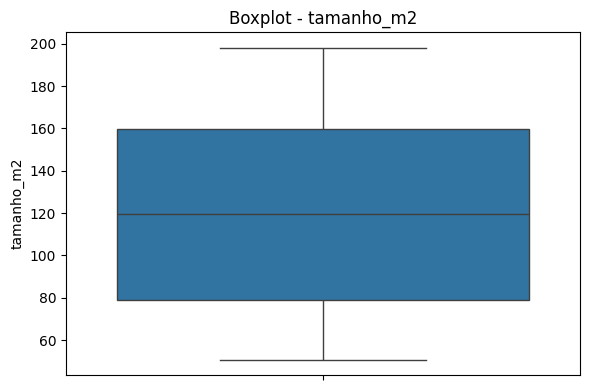

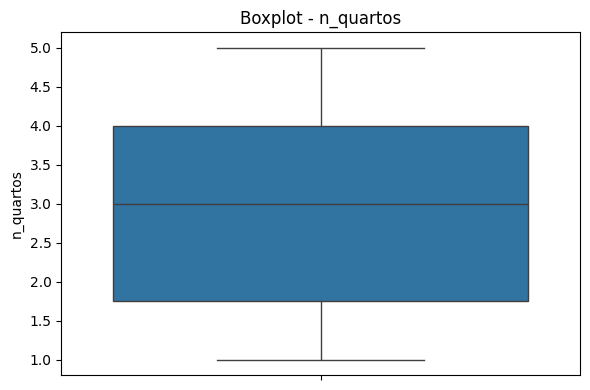

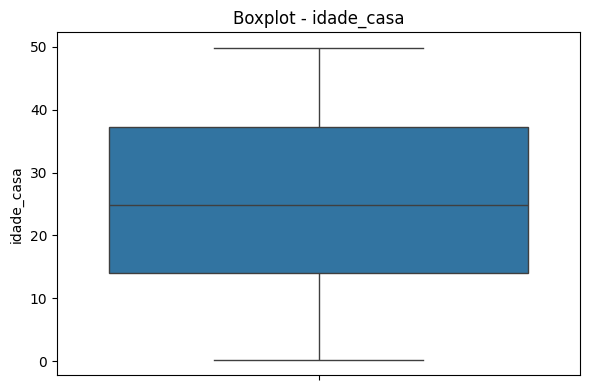

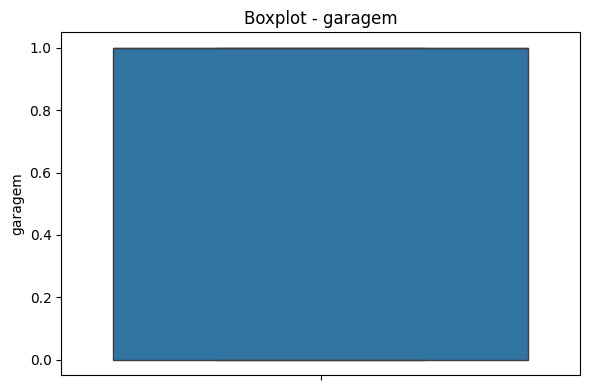

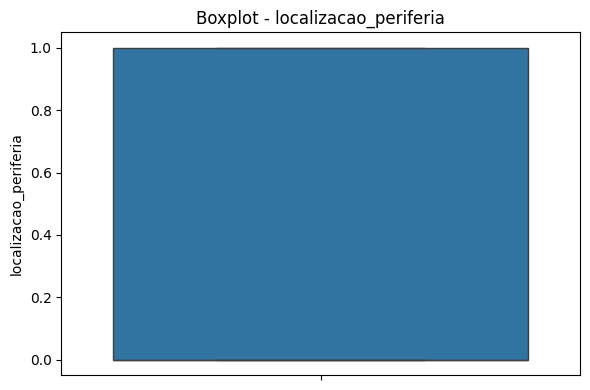

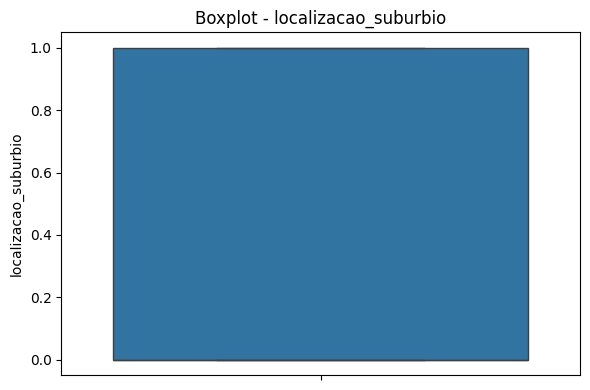

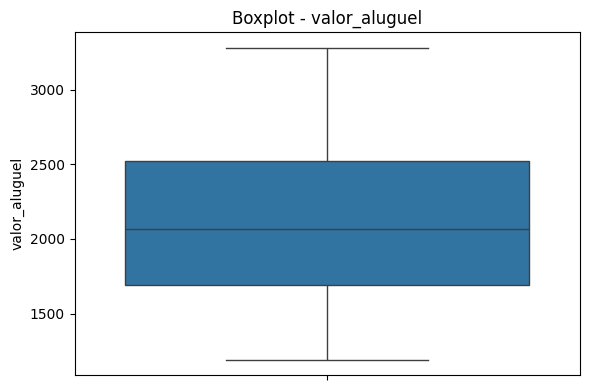

In [266]:
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=df[col])
    plt.title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()


In [267]:
df['garagem'].value_counts()

garagem
1    52
0    48
Name: count, dtype: int64

### Verificando tendências

#### Cruzamento entre variáveis e target

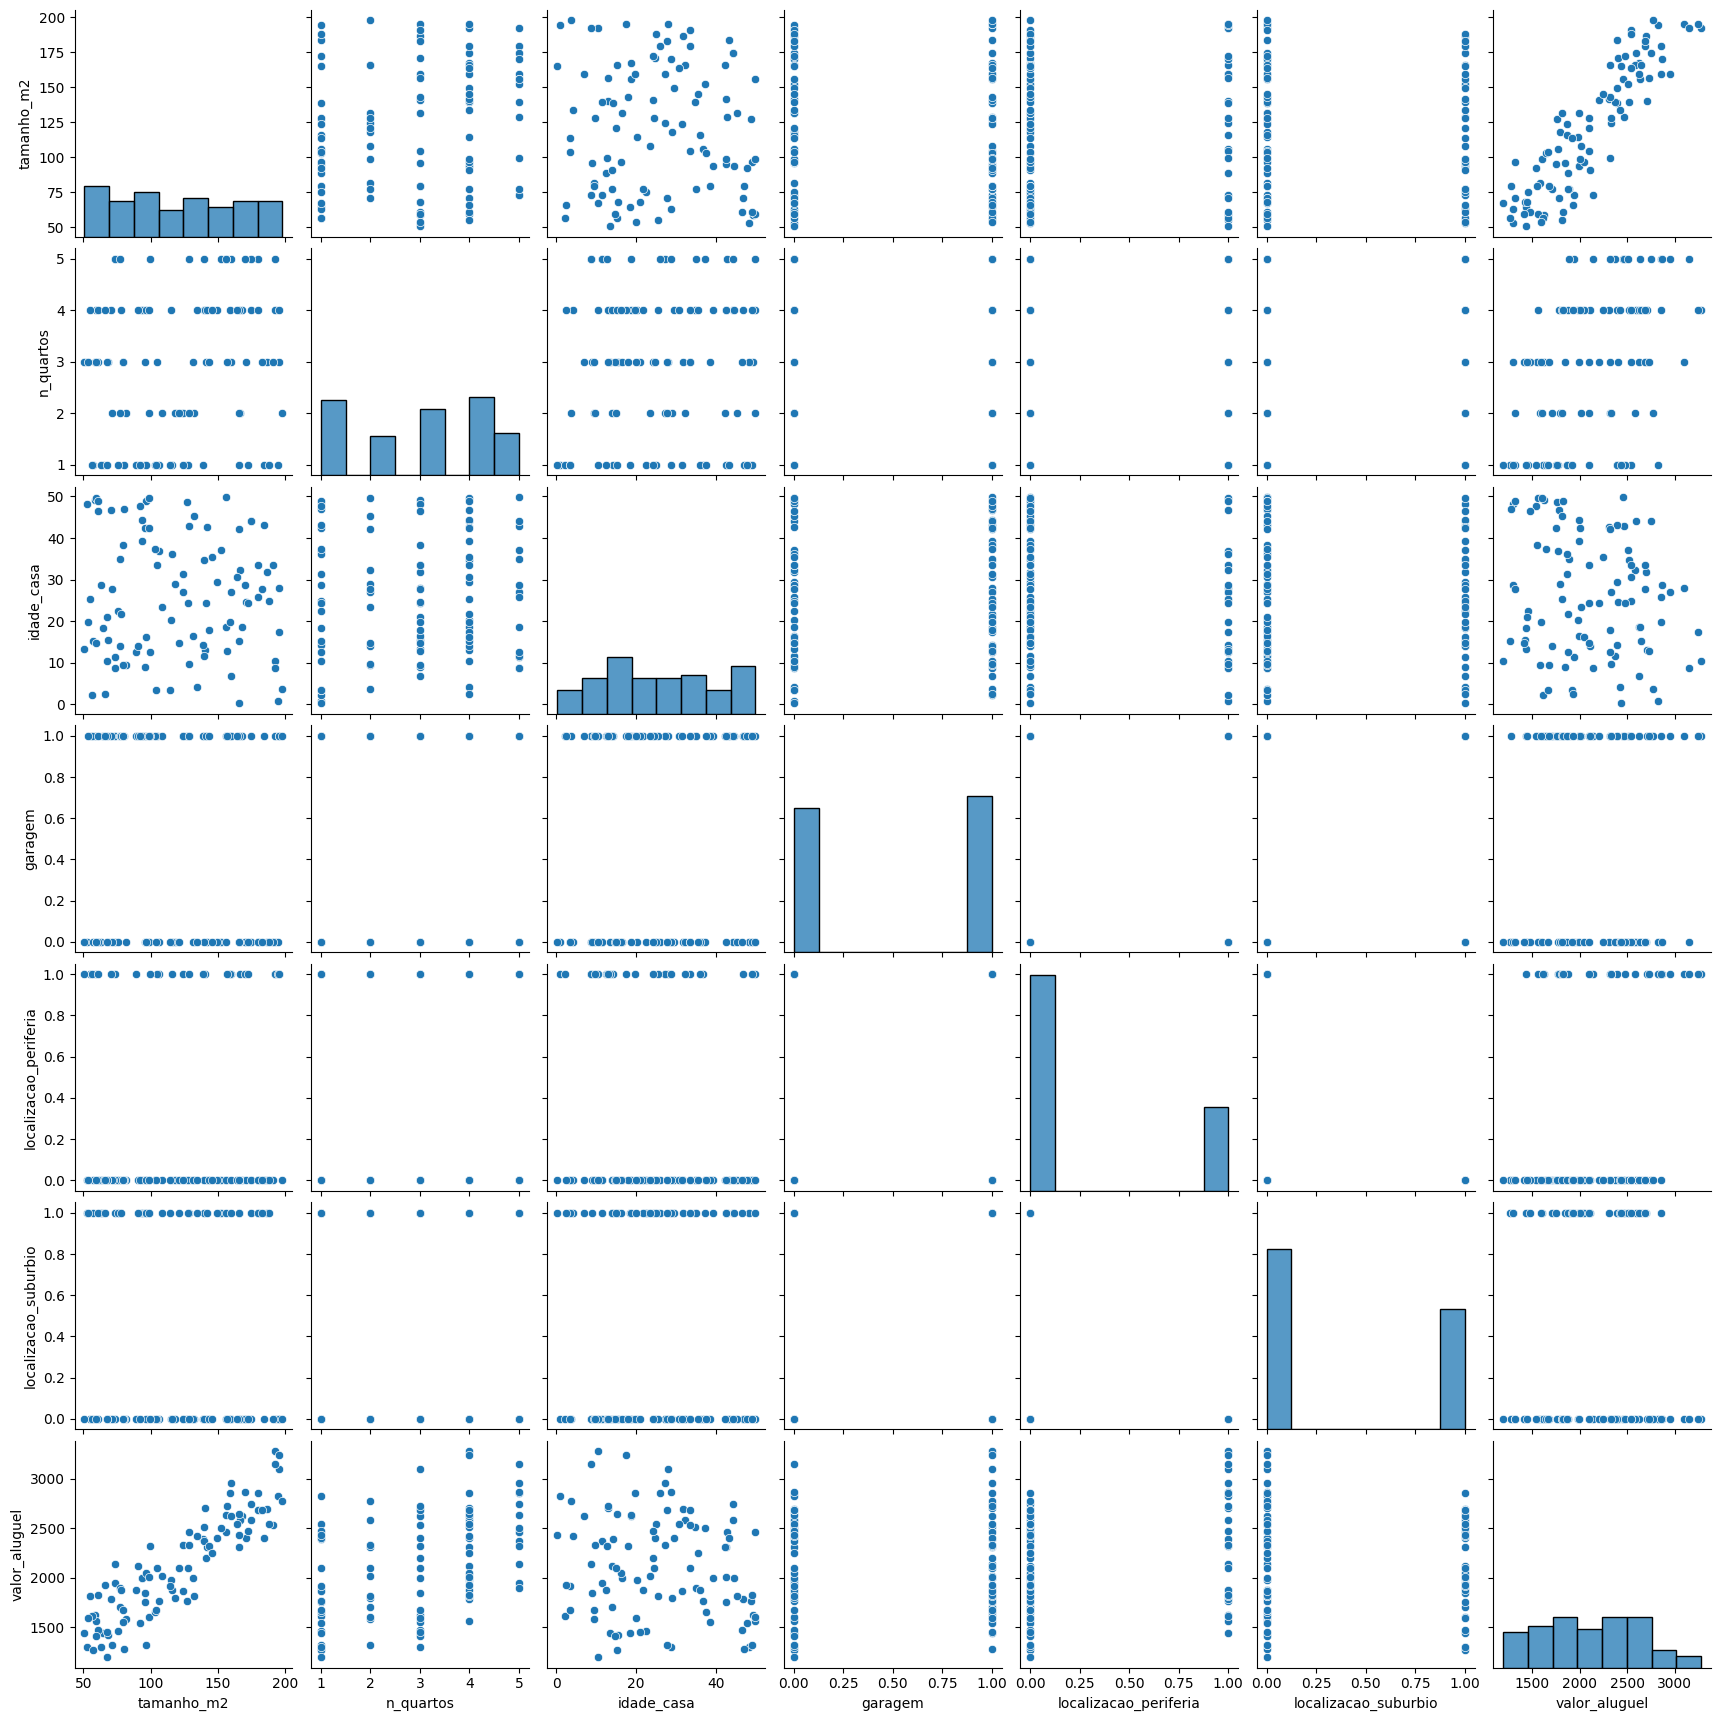

In [268]:
sns.pairplot(data=df)

Não se verifica correlação forte entre variáveis independentes

<Axes: >

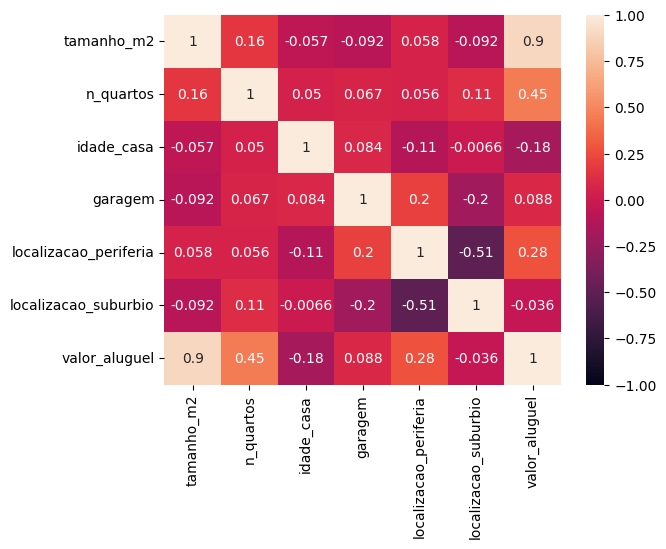

In [269]:
sns.heatmap(data=df_analise.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

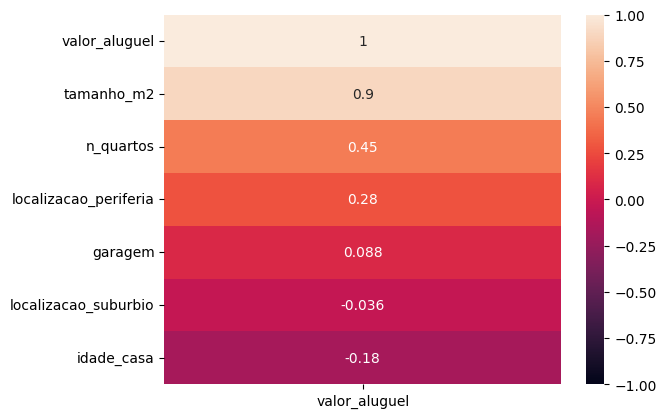

In [270]:
sns.heatmap(data=df_analise.corr()[['valor_aluguel']].sort_values(by='valor_aluguel', ascending=False), vmin=-1, vmax=1, annot=True)

#### Avaliação através de buckets de variáveis numéricas

In [271]:
df.describe()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio,valor_aluguel
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,120.527112,2.910000,25.794810,0.520000,0.280000,0.400000,2112.819084
std,44.623412,1.400541,14.348628,0.502117,0.451261,0.492366,514.314100
min,50.828318,1.000000,0.259243,0.000000,0.000000,0.000000,1192.728727
25%,78.980114,1.750000,13.969405,0.000000,0.000000,0.000000,1694.633091
50%,119.621368,3.000000,24.827177,1.000000,0.000000,0.000000,2069.395680
75%,159.530468,4.000000,37.252879,1.000000,1.000000,1.000000,2520.182679
max,198.033040,5.000000,49.812685,1.000000,1.000000,1.000000,3278.742397


In [272]:
bins_idade = [0, 10, 20, 30, 40, 50]
labels_idade = ['0-10', '10-20', '20-30', '30-40', '40-50']
df_bucket_idade =  df.copy()
df_bucket_idade['escala_idade'] = pd.cut(x=df['idade_casa'], bins=bins_idade, labels=labels_idade, include_lowest=True)
df_bucket_idade.head()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio,valor_aluguel,escala_idade
0,106.181018,1,36.760806,0,1,0,1767.122088,30-40
1,192.607146,4,10.453581,1,1,0,3278.742397,10-20
2,159.799091,5,27.072399,1,1,0,2953.899737,20-30
3,139.798773,4,34.789220,1,0,1,2514.717108,30-40
4,73.402796,5,11.427501,0,0,1,1942.164396,10-20


<Axes: xlabel='escala_idade', ylabel='valor_aluguel'>

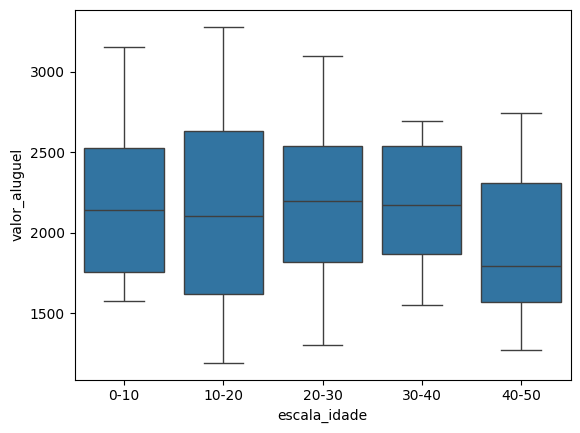

In [273]:
sns.boxplot(data=df_bucket_idade, y=df_bucket_idade['valor_aluguel'], x=df_bucket_idade['escala_idade'])

In [274]:
bins_tamanho = [50, 70, 90, 110, 130, 150, 170, 190, 210]
labels_tamanho = ['50-70', '70-90', '90-110', '110-130', '130-150', '150-170', '170-190', '190-210']
df_bucket_tamanho = df.copy()
df_bucket_tamanho['escala_tamanho_m2'] = pd.cut(x=df_bucket_tamanho['tamanho_m2'], bins=bins_tamanho, labels=labels_tamanho, include_lowest=True)
df_bucket_tamanho.head()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio,valor_aluguel,escala_tamanho_m2
0,106.181018,1,36.760806,0,1,0,1767.122088,90-110
1,192.607146,4,10.453581,1,1,0,3278.742397,190-210
2,159.799091,5,27.072399,1,1,0,2953.899737,150-170
3,139.798773,4,34.789220,1,0,1,2514.717108,130-150
4,73.402796,5,11.427501,0,0,1,1942.164396,70-90


<Axes: xlabel='escala_tamanho_m2', ylabel='valor_aluguel'>

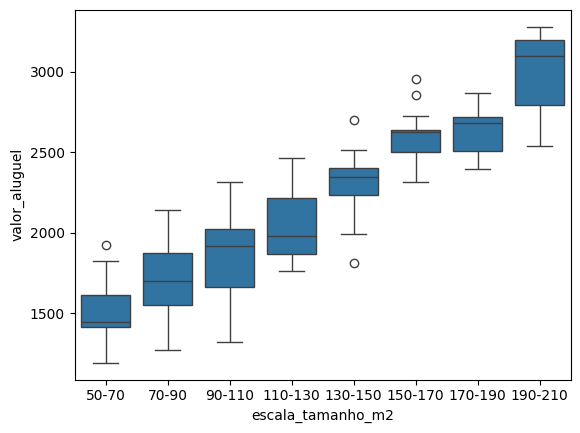

In [275]:
sns.boxplot(data=df_bucket_tamanho, y=df_bucket_tamanho['valor_aluguel'], x=df_bucket_tamanho['escala_tamanho_m2'])

## Criação do modelo

### Separação do conjunto

In [276]:
X = df.drop(columns=['valor_aluguel'])
X.head()

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio
0,106.181018,1,36.760806,0,1,0
1,192.607146,4,10.453581,1,1,0
2,159.799091,5,27.072399,1,1,0
3,139.798773,4,34.789220,1,0,1
4,73.402796,5,11.427501,0,0,1


In [277]:
y = df['valor_aluguel']
y.head()

0    1767.122088
1    3278.742397
2    2953.899737
3    2514.717108
4    1942.164396
Name: valor_aluguel, dtype: float64

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Criação do pipeline

In [279]:
categoricas = []
numericas = ['tamanho_m2', 'n_quartos', 'idade_casa', 'garagem', 'localizacao_periferia', 'localizacao_suburbio']
ordinais = []

In [280]:
transformer_categoricas = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
transformer_numericas = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
transformer_ordinais = Pipeline(steps=[
    ('inputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[[]], handle_unknown='error'))
])

In [281]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', transformer_categoricas, categoricas),
        ('num', transformer_numericas, numericas),
        ('ord', transformer_ordinais, ordinais)
    ]
)

### Criando modelo com o pipeline

In [282]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [283]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Análise do modelo

In [284]:
y_pred = model.predict(X_test)

In [285]:
r2_score(y_test, y_pred)

0.9944862787654796

O r2_score vai de 0 a 1, sendo 1 melhor para a eficiência do modelo

In [286]:
mean_squared_error(y_test, y_pred)

1371.7089130898835

o erro quadrático parece alto para a média de alugueis que é de 2112.81

In [287]:
root_mean_squared_error(y_test, y_pred)

37.03658884252009

### Análise dos resíduos

In [288]:
residuos = y_test - y_pred
residuos.head()

80   -40.829473
84    65.944889
33   -28.355339
81    17.837699
93    19.358763
Name: valor_aluguel, dtype: float64

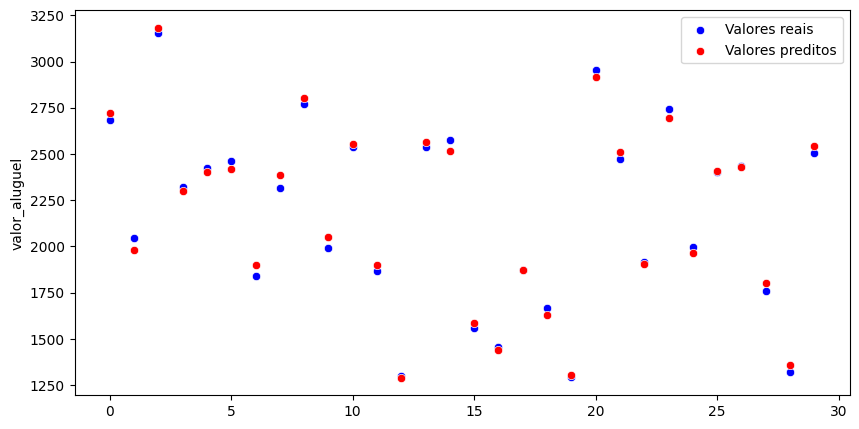

In [289]:
x_axis = range(len(y_test))
plt.figure(figsize=(10,5))
sns.scatterplot(x=x_axis, y=y_test, color='blue', label='Valores reais')
sns.scatterplot(x=x_axis, y=y_pred, color='red', label='Valores preditos')
plt.show()

Aparentemente as previsões chegaram bem perto dos valores reais

In [290]:
residuos_std = zscore(residuos)

#### Testes gráficos

Analisando a normalidade dos resíduos

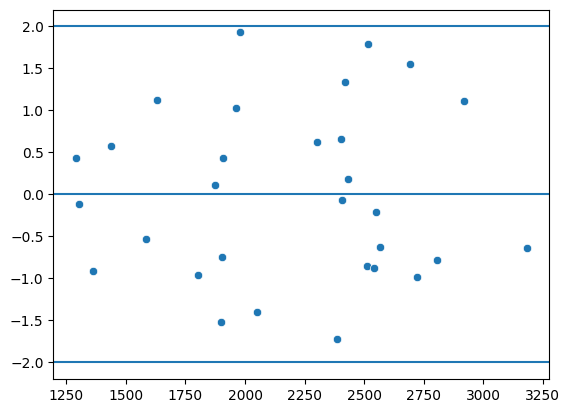

In [291]:
sns.scatterplot(x=y_pred, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=2)
plt.axhline(y=-2)

Todos os residuos ficaram entre -2 e 2 o que é um bom sinal

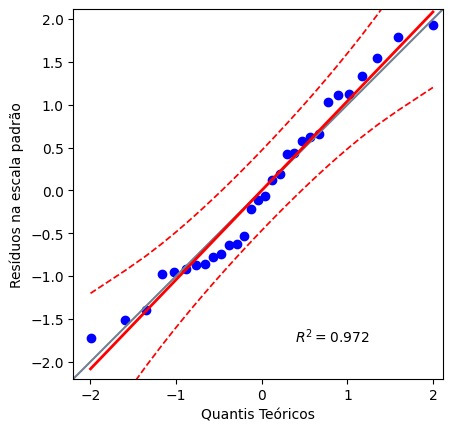

In [311]:
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

os resíduos ficam próximos da linha central o que indica uma distribuição normal

#### Testes estatísticos

h0 - residuos têm distribuição normal  
h1 - resíduos não tem distribuição normal  
p-value > 0.05 -> Não rejeitamos h0

In [293]:
stats_s, p_value_s = shapiro(residuos)
print(f'Estatísticas: {stats_s}, P-value: {p_value_s}')

Estatísticas: 0.9609786229405124, P-value: 0.32806169400913254


p-valor > 0.05 indica normalidade dos resíduos

In [294]:
stats_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estatísticas: {stats_ks}, P-value: {p_value_ks}')

Estatísticas: 0.5333333333333021, P-value: 1.693588718263934e-08


p-value < 0.05 indica não normalidade dos resíduos

In [295]:
stats_l, p_value_l = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estatísticas: {stats_l}, P-value: {stats_l}')

Estatísticas: 0.1322004523584671, P-value: 0.1322004523584671


p-value > 0.05 indica normalidade

In [296]:
stats_a, critical_a, tabela_significancia = anderson(residuos, dist='norm')
print(f'Estatísticas: {stats_a}, critical: {critical_a}, significancia: {tabela_significancia}')

Estatísticas: 0.4167084939239345, critical: [0.521 0.593 0.712 0.83  0.988], significancia: [15.  10.   5.   2.5  1. ]


Para os 50% (0.712) a significancia é maior (5) o que indica que existe uma normalidade na distribuição

Teste de homocedasticidade de Goldfeld-Quandt


In [297]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
X_test_trans = pipe.fit_transform(X=X_test)
X_test_trans

array([[ 1.17851654,  0.73428816,  0.51416214, -0.70710678, -0.60302269,
         1.22474487],
       [-0.80654034,  0.73428816, -0.60217653, -0.70710678, -0.60302269,
         1.22474487],
       [ 1.48693143,  1.38218948, -1.07173227, -0.70710678,  1.6583124 ,
        -0.81649658],
       [ 0.31633765,  0.08638684, -0.4865821 ,  1.41421356, -0.60302269,
        -0.81649658],
       [ 0.09335202,  0.73428816, -1.37381952, -0.70710678, -0.60302269,
         1.22474487],
       [-0.03795214,  1.38218948,  1.10718784,  1.41421356, -0.60302269,
         1.22474487],
       [-0.82943738,  0.08638684, -1.06245342, -0.70710678, -0.60302269,
         1.22474487],
       [-0.73493684,  1.38218948, -0.82118046,  1.41421356,  1.6583124 ,
        -0.81649658],
       [ 1.62355895, -0.56151448, -1.39382797,  1.41421356, -0.60302269,
        -0.81649658],
       [ 0.02654681,  0.08638684, -0.5759182 , -0.70710678, -0.60302269,
        -0.81649658],
       [ 0.81064833,  0.73428816,  0.32320275,  1.

In [298]:
test_goldfeld = het_goldfeldquandt(residuos, X_test_trans)
stat_g = test_goldfeld[0]
p_value_g = test_goldfeld[1]
print(f'Estatísticas: {stat_g}, P-value: {p_value_g}')

Estatísticas: 0.2163960602499194, P-value: 0.983796278633486


p-value > 0.05 indica homocedasticidade

Salvando modelo

In [299]:
joblib.dump(model, './modelo_aluguel.pkl')

['./modelo_aluguel.pkl']

## Realizando predições

In [300]:
df.columns

Index(['tamanho_m2', 'n_quartos', 'idade_casa', 'garagem',
       'localizacao_periferia', 'localizacao_suburbio', 'valor_aluguel'],
      dtype='object')

In [304]:
dados = {
    'tamanho_m2': 100, 
    'n_quartos': 3, 
    'idade_casa': 10, 
    'garagem': 1,
    'localizacao_periferia': 1, 
    'localizacao_suburbio': 0
}
sample = pd.DataFrame(dados, index=[1])
sample

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_periferia,localizacao_suburbio
1,100,3,10,1,1,0


In [310]:
model.predict(sample)

array([2083.07085073])